<a href="https://colab.research.google.com/github/OrJaku/road-sign-recognition/blob/master/road_sign_rec_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
cd drive/My\ Drive/Colab Notebooks/Road_sign_rec

/content/drive/My Drive/Colab Notebooks/Road_sign_rec


In [3]:
import os, shutil, cv2
import pandas as pd
import numpy as np
from keras import layers, models, optimizers

import matplotlib
matplotlib.use('agg')
import matplotlib.pyplot as plt
import matplotlib.image as mpimg 


Using TensorFlow backend.


In [0]:
# new_files_dir = os.path.join(base_dir, 'img_mgr_renamed')
# dest_path = os.path.join(base_dir, 'NoSign')
# for image_name in os.listdir(new_files_dir)
#   src = os.path.join(new_files_dir, image_name)
#   dst = os.path.join(dest_path, image_name)
#   shutil.copyfile(src, dst)
# print("files copied")

### Przygotowanie folderów

In [0]:
base_dir = "Data/"
train_dir = os.path.join(base_dir, 'train_data')
try:
  os.mkdir(train_dir)
except FileExistsError:
  pass


cross_train =  os.path.join(train_dir, 'cross')
stop_train =  os.path.join(train_dir, 'stop')
limit50_train =  os.path.join(train_dir, 'limit50')
nosign_train =  os.path.join(train_dir, 'nosign')
try:
  os.mkdir(nosign_train)
except FileExistsError:
  pass
try:
  os.mkdir(cross_train)
except FileExistsError:
  pass
try:
  os.mkdir(stop_train)
except FileExistsError:
  pass
try:
  os.mkdir(limit50_train)
except FileExistsError:
  pass

valid_dir = os.path.join(base_dir, 'valid_data')
try:
  os.mkdir(valid_dir)
except FileExistsError:
  pass

cross_val =  os.path.join(valid_dir, 'cross')
stop_val =  os.path.join(valid_dir, 'stop')
limit50_val =  os.path.join(valid_dir, 'limit50')
nosign_val =  os.path.join(valid_dir, 'nosign')

try:
  os.mkdir(nosign_val)
except FileExistsError:
  pass
try:
  os.mkdir(cross_val)
except FileExistsError:
  pass
try:
  os.mkdir(stop_val)
except FileExistsError:
  pass
try:
  os.mkdir(limit50_val)
except FileExistsError:
  pass

test_dir = os.path.join(base_dir, 'test_data')
try:
  os.mkdir(test_dir)
except FileExistsError:
  pass

cross_test =  os.path.join(test_dir, 'cross')
stop_test =  os.path.join(test_dir, 'stop')
limit50_test =  os.path.join(test_dir, 'limit50')
nosign_test =  os.path.join(test_dir, 'nosign')


try:
  os.mkdir(nosign_test)
except FileExistsError:
  pass
try:
  os.mkdir(cross_test)
except FileExistsError:
  pass
try:
  os.mkdir(stop_test)
except FileExistsError:
  pass
try:
  os.mkdir(limit50_test)
except FileExistsError:
  pass


#### Ilość poszczegónych zdjęć

In [5]:
cross_origin_path = os.path.abspath("Data/information--pedestrians-crossing--g1/")
stop_origin_path = os.path.abspath("Data/regulatory--stop--g1")
limit50_origin_path = os.path.abspath("Data/regulatory--maximum-speed-limit-50--g1")
nosign_path = os.path.abspath("Data/NoSign")
nosign_path_2 = os.path.abspath("Data/NoSign2")



print('Przejscie dla piszych: ',len(os.listdir(cross_origin_path)))
print('Stop: ', len(os.listdir(stop_origin_path)))
print('Ograniczenie do 50km/h: ', len(os.listdir(limit50_origin_path)))
number_of_nosign = len(os.listdir(nosign_path)) + len(os.listdir(nosign_path_2))
print('Brak znaku', number_of_nosign)

Przejscie dla piszych:  2188
Stop:  1368
Ograniczenie do 50km/h:  711
Brak znaku 4129


#### Kopiowanie danych 

---



In [55]:

# # train cross
# for image_name in os.listdir(cross_origin_path)[0:1200]:
#   src = os.path.join(cross_origin_path, image_name)
#   dst = os.path.join(cross_train, image_name)
#   shutil.copyfile(src, dst)
# print("train cross copied")

# # validation cross
# for image_name in os.listdir(cross_origin_path)[1200:1800]:
#   src = os.path.join(cross_origin_path, image_name)
#   dst = os.path.join(cross_val, image_name)
#   shutil.copyfile(src, dst)
# print("validation cross copied")

# # test cross
# for image_name in os.listdir(cross_origin_path)[1800:]:
#   src = os.path.join(cross_origin_path, image_name)
#   dst = os.path.join(cross_test, image_name)
#   shutil.copyfile(src, dst)
# print("test cross copied")

# ##################################

# # train stop
# i=0
# for image_name in os.listdir(stop_origin_path)[0:900]:
#   i =+ 1
#   src = os.path.join(stop_origin_path, image_name)
#   dst = os.path.join(stop_train, image_name)
#   shutil.copyfile(src, dst)
#   if i == 200 or i == 400 or i == 700:
#     print(f"Copied {i} ")
# print("train stop copied")


# # validation stop
# for image_name in os.listdir(stop_origin_path)[901:1200]:
#   src = os.path.join(stop_origin_path, image_name)
#   dst = os.path.join(stop_val, image_name)
#   shutil.copyfile(src, dst)
#   if i == 1050:
#     print(f"Copied {i} ")
# print("validation stop copied")

# # test stop
# for image_name in os.listdir(stop_origin_path)[1201:]:
#   src = os.path.join(stop_origin_path, image_name)
#   dst = os.path.join(stop_test, image_name)
#   shutil.copyfile(src, dst)
#   if i == 1300:
#     print(f"Copied {i} ")
# print("test stop copied")


# ##########################

# # train limit50
# for image_name in os.listdir(limit50_origin_path)[0:400]:
#   src = os.path.join(limit50_origin_path, image_name)
#   dst = os.path.join(limit50_train, image_name)
#   shutil.copyfile(src, dst)
# print("train limit50 copied")

# # validation limit50
# for image_name in os.listdir(limit50_origin_path)[400:600]:
#   src = os.path.join(limit50_origin_path, image_name)
#   dst = os.path.join(limit50_val, image_name)
#   shutil.copyfile(src, dst)
# print("validation limit50 copied")

# # test limit50
# for image_name in os.listdir(limit50_origin_path)[600:]:
#   src = os.path.join(limit50_origin_path, image_name)
#   dst = os.path.join(limit50_test, image_name)
#   shutil.copyfile(src, dst)
# print("test limit50 copied")


##########################


# train NoSign
for image_name in os.listdir(nosign_path_2)[0:1300]:
  src = os.path.join(nosign_path_2, image_name)
  dst = os.path.join(nosign_train, image_name)
  shutil.copyfile(src, dst)
print("train NoSign copied")

# validation NoSign
for image_name in os.listdir(nosign_path_2)[1300:1700]:
  src = os.path.join(nosign_path_2, image_name)
  dst = os.path.join(nosign_val, image_name)
  shutil.copyfile(src, dst)
print("validation NoSign copied")

# test NoSign
for image_name in os.listdir(nosign_path_2)[1700:]:
  src = os.path.join(nosign_path_2, image_name)
  dst = os.path.join(nosign_test, image_name)
  shutil.copyfile(src, dst)
print("test NoSign copied")



train NoSign copied
validation NoSign copied
test NoSign copied


#### Przekształcanie plików .jpg na tensory

In [6]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)

picture_size = 100

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(picture_size,picture_size),
    batch_size=10,
    class_mode='categorical'

)

valid_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=(picture_size,picture_size),
    batch_size=10,
    class_mode='categorical'

)
numer_of_classes = len(train_generator.class_indices)

Found 5215 images belonging to 4 classes.
Found 2014 images belonging to 4 classes.


In [0]:
INIT_LR = 1e-3
epochs = 50
opt = optimizers.Adam(lr=INIT_LR, decay=INIT_LR / epochs)


##Model class classification

In [0]:

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(picture_size, picture_size, 3)))
model.add(layers.MaxPool2D((2, 2)))
model.add(layers.Dropout(0.3))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPool2D((2, 2)))
model.add(layers.Dropout(0.3))

model.add(layers.Conv2D(128, (3,3), activation='relu'))
model.add(layers.MaxPool2D((2, 2)))
model.add(layers.Dropout(0.3))

model.add(layers.Conv2D(128, (3,3), activation='relu'))
model.add(layers.MaxPool2D((2, 2)))
model.add(layers.Dropout(0.3))

model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dense(numer_of_classes, activation='softmax'))

model.compile(
    loss='categorical_crossentropy',
    optimizer=opt,
    metrics=['acc']
    )
model.summary()


Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 98, 98, 32)        896       
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 49, 49, 32)        0         
_________________________________________________________________
dropout_25 (Dropout)         (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 47, 47, 64)        18496     
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 23, 23, 64)        0         
_________________________________________________________________
dropout_26 (Dropout)         (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 21, 21, 128)      

##Model multi-classes classification

In [0]:

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(picture_size, picture_size, 3)))
model.add(layers.MaxPool2D((2, 2)))
model.add(layers.Dropout(0.3))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPool2D((2, 2)))
model.add(layers.Dropout(0.3))

model.add(layers.Conv2D(128, (3,3), activation='relu'))
model.add(layers.MaxPool2D((2, 2)))
model.add(layers.Dropout(0.3))

model.add(layers.Conv2D(128, (3,3), activation='relu'))
model.add(layers.MaxPool2D((2, 2)))
model.add(layers.Dropout(0.3))

model.add(layers.Conv2D(128, (3,3), activation='relu'))
model.add(layers.MaxPool2D((2, 2)))
model.add(layers.Dropout(0.25))

model.add(layers.Flatten())
model.add(layers.Dense(1024, activation="relu"))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.25))
model.add(layers.Dense(numer_of_classes))
model.add(layers.Activation('sigmoid'))

model.compile(
    loss='categorical_crossentropy',
    optimizer=opt,
    metrics=['acc']
    )
model.summary()

In [9]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=epochs,
    validation_data=valid_generator,
    validation_steps=10
)

Epoch 1/50
100/100 [==============================] - 550s 5s/step - loss: 1.0698 - acc: 0.5990 - val_loss: 0.8747 - val_acc: 0.6400
Epoch 2/50
100/100 [==============================] - 555s 6s/step - loss: 0.7242 - acc: 0.7960 - val_loss: 0.6545 - val_acc: 0.7700
Epoch 3/50
100/100 [==============================] - 535s 5s/step - loss: 0.5396 - acc: 0.8221 - val_loss: 0.4519 - val_acc: 0.8700
Epoch 4/50
100/100 [==============================] - 547s 5s/step - loss: 0.5189 - acc: 0.8450 - val_loss: 0.5025 - val_acc: 0.8200
Epoch 5/50
100/100 [==============================] - 530s 5s/step - loss: 0.4850 - acc: 0.8650 - val_loss: 0.4501 - val_acc: 0.9100
Epoch 6/50
100/100 [==============================] - 128s 1s/step - loss: 0.4485 - acc: 0.8530 - val_loss: 0.2963 - val_acc: 0.8300
Epoch 7/50
100/100 [==============================] - 51s 514ms/step - loss: 0.3574 - acc: 0.8930 - val_loss: 0.0673 - val_acc: 0.9100
Epoch 8/50
100/100 [==============================] - 66s 664ms/ste

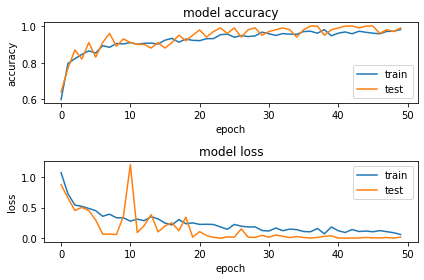

In [11]:
fig = plt.figure()
plt.subplot(2,1,1)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')

plt.subplot(2,1,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

plt.tight_layout()

fig

In [0]:
model_name = 'model_signs_4_classes.h5'
model_path = os.path.join(base_dir, model_name)
model.save(model_path)

In [0]:
model_name = 'model_signs_4_multi_classes.h5'
model_path = os.path.join(base_dir, model_name)
model.save(model_path)

In [0]:
model.load_weights('Data/model_signs_4_classes.h5')


In [0]:
ls

Data/  road_sign_rec_model.ipynb


In [0]:
# to_del = os.path.join(test_dir, '.ipynb_checkpoints')
# os.rmdir(to_del)

In [0]:
pwd

'/content/drive/My Drive/Colab Notebooks/Road_sign_rec'

In [0]:
# !mv Data/test_data/stop Data/test_data/stop1 
# !mv Data/test_data/cross Data/test_data/stop 
# !mv Data/test_data/stop1 Data/test_data/cross 


mv: cannot stat 'Data/test_data/stop': No such file or directory


In [14]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(picture_size, picture_size),
        color_mode="rgb",
        shuffle = False,
        class_mode='categorical',
        batch_size=1)

filenames = test_generator.filenames
classes_gen = test_generator.class_indices
classes_gen

Found 1446 images belonging to 4 classes.


{'cross': 0, 'limit50': 1, 'nosign': 2, 'stop': 3}

In [15]:
predict = model.predict_generator(test_generator,steps = len(filenames))
predict

KeyboardInterrupt: ignored

In [16]:
loss_acc = model.evaluate(test_generator)
print('loss= ', loss_acc[0])
print("acc= ", loss_acc[1])

1446/1446 [==============================] - 194s 134ms/step
loss=  2.5570720026735216e-05
acc=  0.9840940237045288


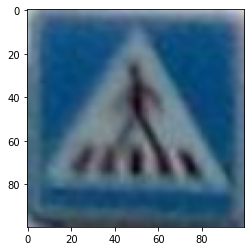

In [0]:
figure = plt.figure()
files = os.path.join(test_dir, 'cross')
test_files = os.listdir(files)

path_to_test = os.path.join(files, test_files[100])
img = cv2.imread(path_to_test)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img,(picture_size,picture_size))
plt.imshow(img)
plt.show()
figure

In [17]:
import matplotlib.pyplot as plt
signs = ['limit50', 'stop', 'cross', 'nosign']

fig = plt.figure()

for sign in signs:
  files = os.path.join(test_dir, sign)
  test_files = os.listdir(files)
  incorrect = 0
  for f in test_files:
    path_to_test = os.path.join(files, f)
    img = cv2.imread(path_to_test)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    img = cv2.resize(img,(picture_size,picture_size))
    img = img.astype("float32") / 255
    if incorrect == 2:
      plt.imshow(img)
      plt.show()

    img_tensor = np.reshape(img,[1,picture_size,picture_size,3])
    classes = (model.predict_classes(img_tensor)).tolist()
    # print(classes)
    if classes[0] == 0:
      classes = 'cross'
    
    elif classes[0] == 3:
      classes = 'stop'

    elif classes[0] == 1:
      classes = 'limit50'
    
    elif classes[0] == 2:
      classes = 'nosign'

    else:
      classes

    if classes != sign:
      incorrect += 1 
      plt.imshow(img)

  print(f'{sign}: {incorrect} / {len(test_files)},  Correct: {round(100-(incorrect/len(test_files)*100))}%')

  fig


limit50: 5 / 111,  Correct: 95%
stop: 5 / 167,  Correct: 97%
cross: 3 / 388,  Correct: 99%
nosign: 11 / 780,  Correct: 99%
